# Pekka ja susi: Realistinen ympäristö

Meidän tilanteessamme Pekka pystyi liikkumaan lähes väsymättä tai tuntematta nälkää. Todellisemmassa maailmassa hänen täytyy välillä istua alas ja levätä, sekä syödä jotain. Tehdään maailmastamme realistisempi toteuttamalla seuraavat säännöt:

1. Liikkuessaan paikasta toiseen Pekka menettää **energiaa** ja kerää **väsymystä**.
2. Pekka voi saada lisää energiaa syömällä omenoita.
3. Pekka voi päästä eroon väsymyksestä lepäämällä puun alla tai ruohikolla (eli siirtymällä pelilaudan kohtaan, jossa on puu tai ruoho - vihreä alue).
4. Pekan täytyy löytää ja tappaa susi.
5. Jotta Pekka voi tappaa suden, hänen täytyy olla tietyllä energian ja väsymyksen tasolla, muuten hän häviää taistelun.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

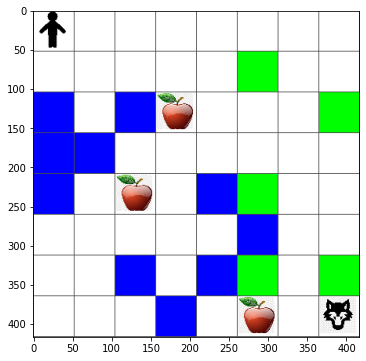

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Tilanteen määrittäminen

Uusissa pelisäännöissämme meidän täytyy seurata energiaa ja väsymystä jokaisessa pelilaudan tilassa. Siksi luomme olion `state`, joka sisältää kaiken tarvittavan tiedon nykyisestä ongelmatilasta, mukaan lukien pelilaudan tilan, nykyiset energian ja väsymyksen tasot sekä sen, voimmeko voittaa suden päätetilassa:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Yritetään ratkaista ongelma satunnaiskävelyn avulla ja katsotaan, onnistummeko:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Palkkiofunktio

Palkkiofunktio on keskeinen osa vahvistusoppimista, sillä se ohjaa agentin toimintaa kohti tavoiteltua käyttäytymistä. Hyvin suunniteltu palkkiofunktio voi nopeuttaa oppimista ja parantaa suorituskykyä, kun taas huonosti suunniteltu funktio voi johtaa ei-toivottuihin tuloksiin.

### Palkkioiden suunnittelun periaatteet

[!NOTE] Palkkiofunktioiden suunnittelu vaatii huolellista harkintaa ja testausta.

1. **Yksinkertaisuus on avainasemassa**  
   Pidä palkkiofunktio mahdollisimman yksinkertaisena. Monimutkaiset funktiot voivat tehdä oppimisprosessista vaikeasti ennustettavan.

2. **Kannusta haluttua käyttäytymistä**  
   Varmista, että palkkiot ohjaavat agenttia kohti tavoitetta. Esimerkiksi, jos agentin tehtävänä on saavuttaa tietty piste, anna positiivinen palkkio, kun se saavuttaa sen.

3. **Vältä ei-toivottuja sivuvaikutuksia**  
   Joskus palkkiofunktio voi johtaa odottamattomiin tuloksiin. Testaa funktiota huolellisesti ja varmista, ettei agentti löydä "kikkailutapoja" maksimoida palkkioita ilman, että se suorittaa tehtävää oikein.

### Esimerkki palkkiofunktiosta

Alla on yksinkertainen esimerkki palkkiofunktiosta, joka kannustaa agenttia liikkumaan kohti tavoitetta:

```python
def reward_function(agent_position, target_position):
    distance = calculate_distance(agent_position, target_position)
    if distance == 0:
        return 100  # Suuri palkkio tavoitteen saavuttamisesta
    else:
        return -distance  # Negatiivinen palkkio etäisyyden perusteella
```

Tässä esimerkissä agentti saa suuren positiivisen palkkion, kun se saavuttaa tavoitteen, ja negatiivisen palkkion, joka perustuu sen etäisyyteen tavoitteesta.

### Yleisiä virheitä palkkiofunktioiden suunnittelussa

[!WARNING] Vältä seuraavia yleisiä virheitä:

- **Liian monimutkaiset funktiot:** Monimutkaisuus voi hidastaa oppimista ja tehdä tuloksista vaikeasti tulkittavia.
- **Epätasapainoiset palkkiot:** Jos tietyt palkkiot ovat liian suuria tai pieniä suhteessa muihin, agentti voi keskittyä vain yhteen osa-alueeseen tehtävässä.
- **Ei-toivottujen strategioiden palkitseminen:** Testaa funktiota varmistaaksesi, ettei agentti löydä tapoja "huijata" järjestelmää.

### Yhteenveto

Palkkiofunktioiden suunnittelu on kriittinen osa vahvistusoppimista. Hyvin suunniteltu funktio voi merkittävästi parantaa agentin suorituskykyä ja oppimisnopeutta. Muista testata ja säätää funktiota tarpeen mukaan varmistaaksesi, että se ohjaa agenttia kohti haluttua käyttäytymistä.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning-algoritmi

Varsinainen oppimisalgoritmi pysyy lähes muuttumattomana, käytämme vain `state`-tilaa pelkän laudan sijainnin sijasta.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

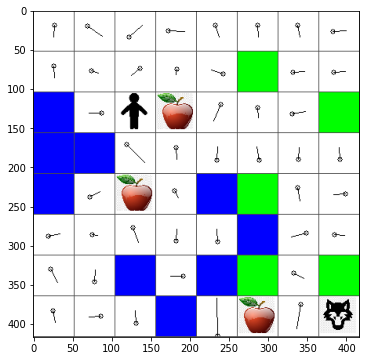

In [11]:
m.plot(Q)

## Tulokset

Katsotaanpa, onnistuimmeko kouluttamaan Peterin taistelemaan sutta vastaan!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Näemme nyt paljon vähemmän hukkumistapauksia, mutta Peter ei silti aina pysty tappamaan sutta. Yritä kokeilla ja katso, voitko parantaa tätä tulosta säätämällä hyperparametreja.


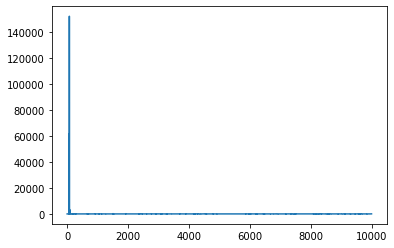

In [13]:
plt.plot(lpath)


---

**Vastuuvapauslauseke**:  
Tämä asiakirja on käännetty käyttämällä tekoälypohjaista käännöspalvelua [Co-op Translator](https://github.com/Azure/co-op-translator). Vaikka pyrimme tarkkuuteen, huomioithan, että automaattiset käännökset voivat sisältää virheitä tai epätarkkuuksia. Alkuperäistä asiakirjaa sen alkuperäisellä kielellä tulee pitää ensisijaisena lähteenä. Kriittisen tiedon osalta suositellaan ammattimaista ihmiskääntämistä. Emme ole vastuussa tämän käännöksen käytöstä aiheutuvista väärinkäsityksistä tai virhetulkinnoista.
